# Taustaa ja kysymyksen asettelu

Työn tavoitteena oli kerätä tietoa myytävänä olevista autoista ja tutkia kuinka hyvin tietyillä piirteillä voidaan ennustaa niiden hintaa. Myös sopivaa piirteiden yhdistelmää ja ennustinmallia oli tarkoitus kartoittaa. Työ voi tarjota ”tilaajalle” tietoa kuinka hyvin yksinkertaisilla piirteillä voidaan ennustaa autolle hintaa käyttäen sopivaa ennustinmallia ja millaista epävarmuutta hintaennustimeen sisältyy. 

Datasettiä lähdettiin rakentamaan niin että siihen kerättiin vuosimalleja 2005-2021 ja kaikki autot olivat bensiini moottorilla. Lisäksi poimittiin mukaan datasettiin seuraavat merkit: Audi, BMW, Nissan, Skoda, Toyota ja Volkswagen. Kustakin merkistä poimittiin kolme suosittua mallia ja niistä pyrittiin kustakin kerämään 300 näytettä. Siis kokonaisuudessan olisi voinut saada 4500 näytettä kyseisellä haulla mutta koska kaikissa malleissa ei ollut myytävänä niin paljon autoja, datasetin koko jäi n.3882 näytteeseen.
Käyttämällä ruudun raavintaa data kerättiin Autotalli.com sivustolta ja raavinta tehtiin kahdessa erässä. Raavittu data kerättiin kahteen .json tiedostoon josta ne luettiin Pandas kirjastoiksi.

## Kirjastojen lataaminen, datatiedostot

In [2]:
#Ladataan tarvittavat kirjastot sisään
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn import preprocessing
from urllib.parse import unquote

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
plt.rcParams['figure.figsize'] = (15, 7)

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import ipywidgets as widgets
from IPython.display import display


_______________________________________________________________________________________________________________________________

In [3]:
# luetaan json tiedostot sisään pandas dataframeiksi. enkoodaus utf-8
df_org1 = pd.read_json("SCRAPY_DATA/setti1.json", encoding= 'utf-8') # Tiedosto1 on JSON formaattia
df_org2 = pd.read_json("SCRAPY_DATA/setti2.json", encoding= 'utf-8') # Tiedosto2 on JSON formaattia

## Datan tutkiminen ja jalostaminen

Tavoitteena jalostamisvaiheessa oli käydä datasetistä läpi kaikki sarakkeet ja tutkia niiden formaattia sekä pyrkiä jakamaan niiden sisältöä helposti ymmärrettävään muotoon sekä numeeriseksi muunnettavaan muotoon. Luetaan ensimmäiseksi datasetit sisään jonka jälkeen tutkitaan setin muotoa, formaatteja ja varmistetaan että nollarivejä ei ole. Datasetit jaettiin kahteen osaan, koska scrapy törmäsi helposti time-out ongelmaan. 

In [4]:
#printataan ensimmäiset viisi riviä tietoa datasetistä, jotta hahmotamme datan rakenteen
df_org1.head()

,OTSIKKO,VM.,AJETTU,HINTA,URL,LINKKI ILMOITUKSEEN,HAUN AIKA
0,BMW 525 i Touring E61,2005,234000,5930,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38087770/...,Tue Apr 20 15:56:05 2021
1,BMW 525 i Touring E61 A. Suomiauto. Kats 10/2021.,2005,249000,5990,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38070205/...,Tue Apr 20 15:56:05 2021
2,BMW 525 *NELIVETO* BMW 525xi 4d A. Tarkastettu...,2006,236000,7490,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38082748/...,Tue Apr 20 15:56:05 2021
3,BMW 523 E61 Touring #PANORAAMAKATTO #SUOMIAUTO,2006,230000,7500,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37992120/...,Tue Apr 20 15:56:05 2021
4,BMW 530 i 4d *HYVIN HUOLLETTU SUOMI-AUTO* * RA...,2007,299000,7850,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37961878/...,Tue Apr 20 15:56:05 2021


In [5]:
#Testataan mitä luetusta json tiedostosta1 löytyy, nyt kun se on luettu sisään Pandas dictionaryna.
df_org1.keys()

Index(['OTSIKKO', 'VM.', 'AJETTU', 'HINTA', 'URL', 'LINKKI ILMOITUKSEEN',
       'HAUN AIKA'],
      dtype='object')

In [6]:
#Testataan mitä luetusta json tiedostosta2 löytyy, nyt kun se on luettu sisään Pandas dictionaryna. Varmistetaan siis että dataframet ovat yhtenevät
df_org2.keys()

Index(['OTSIKKO', 'VM.', 'AJETTU', 'HINTA', 'URL', 'LINKKI ILMOITUKSEEN',
       'HAUN AIKA'],
      dtype='object')

In [7]:
#tarkastetaan Dtypet sarakkeista setissä 1, todetaan että osa datasta onkin jo sopivasti numeerisessa muodossa
df_org1.dtypes

OTSIKKO                object
VM.                     int64
AJETTU                  int64
HINTA                   int64
URL                    object
LINKKI ILMOITUKSEEN    object
HAUN AIKA              object
dtype: object

In [8]:
#tarkastetaan Dtypet sarakkeista setissä 2
df_org2.dtypes

OTSIKKO                object
VM.                     int64
AJETTU                  int64
HINTA                   int64
URL                    object
LINKKI ILMOITUKSEEN    object
HAUN AIKA              object
dtype: object

In [9]:
#tarkastellaan datasetin1 kokoa
df_org1.shape

(1653, 7)

In [10]:
#tarkastellaan datasetin2 kokoa
df_org2.shape

(2229, 7)

In [11]:
# yhdistetään datasetit, tässä tulee concat komennon sijaan käyttää merge. Concat yhdistää datasetit ikään kuin sisäkkäin
#jolloin esim. df_org.at[0,"OTSIKKO"] tuloksella saadaan kaksi arvoa. Kun merge komennolla käytetään "outer" vaatimusta
#yhdistyy dataseteistä vain toisistaan poikkeavat arvot
df_org = pd.merge(df_org1, df_org2, how="outer")

In [12]:
#tarkastetaan vielä yhdistetyn datasetin koko
df_org.shape

(3882, 7)

In [13]:
#Tarkastetaan että nolla-arvoja tai NaN arvoja datasetissä ei varmasti ole
df_org.isnull().values.any()

False

In [14]:
#Tarkastetaan että nolla-arvoja tai NaN arvoja datasetissä ei varmasti ole
df_org.isna().values.any()

False

In [15]:
#Tutkitaan miltä linkki näyttää datasetissä
df_org.iat[1,5]

'https://www.autotalli.com/vaihtoauto/38070205/BMW/525/2005/H%C3%A4meenlinna?pos=1&page=1&searchType=usedCar'

In [16]:
#Huomataan että datasetissä eivät Ä:t ja Ö:t ole kääntyneet oikein joten käsitellään ne.
#Hyödynnetään tähän urllib.parse unquote toimintoa ja luupataan läpi sarakkeet joissa nimi on joko "OTSIKKO" tai "LINKKI ILMOITUKSEEN"
for rowIndex, row in df_org.iterrows(): #iterate over rows
    for columnIndex, value in row.items():
        if columnIndex=="OTSIKKO":
            
            df_org.at[rowIndex,columnIndex]=unquote(value)
            
        if columnIndex=="LINKKI ILMOITUKSEEN":
            
            df_org.at[rowIndex,columnIndex]=unquote(value)
            
    

In [17]:
#Kokeillaan nyt että Ä:t ja Ö:t ovat oikein kaupungin nimissä
df_org.iat[1,5]

'https://www.autotalli.com/vaihtoauto/38070205/BMW/525/2005/Hämeenlinna?pos=1&page=1&searchType=usedCar'

In [18]:
#nähdään että URL ja LINKKI ILMOITUKSEEN ovat itse asiassa linkkejä myös Jupyter Notebookissa
df_org.iloc[1]

OTSIKKO                BMW 525 i Touring E61 A. Suomiauto. Kats 10/2021.
VM.                                                                 2005
AJETTU                                                            249000
HINTA                                                               5990
URL                    https://www.autotalli.com/vaihtoautot/listaa/b...
LINKKI ILMOITUKSEEN    https://www.autotalli.com/vaihtoauto/38070205/...
HAUN AIKA                                       Tue Apr 20 15:56:05 2021
Name: 1, dtype: object

In [19]:
#jaetaan URL sarake kahtia niin että poimitaan siitä erikseen sekä Merkki että Malli, jotka käyvät ilmi autotallin hausta
#luodaan erillinen lista ensin URL sarakkeesta
URL_temp=df_org['URL']
#ja poistetaan se originaalista, koska emme tarvitse sitä sellaisenaan
#del df_org['URL']

In [20]:
#tutiktaan miltä URL näyttää ja mitä kyselyyn sisältyy
URL_temp.iat[200]

'https://www.autotalli.com/vaihtoautot/listaa/audi/a3/polttoaine/bensiini/vuosimalli_min/2005/sivu/2/max_osumia/100/jarjestys/current_price:asc'

In [21]:
#Käydään läpi temp lista for loopilla ja luodaan siitä kaksi uuttaa listaa: Merkki ja Malli
#määritellään ensin regexille hakija pelkille sanoille html:stä
jakaja = re.compile("\w+")
merkki=[]
malli=[]

for i in range((URL_temp.shape[0])):
    #splitataan linkki listaksi sanoja käyttäen aikaisemmin määriteltyä jakajaa 
    tulos=jakaja.findall(URL_temp.iat[i])
    #tiedetään että Merkki ja malli ovat html:ssä aina samassa välissä
    merkki_temp=tulos[6]
    malli_temp=tulos[7]
    merkki.append(merkki_temp)
    malli.append(malli_temp)
    


In [22]:
#lisätään alkuperäiseen pandas luetteloon Merkki ja Malli listat
df_org['Merkki']=merkki
df_org['Malli']=malli

In [23]:
df_org.head()

,OTSIKKO,VM.,AJETTU,HINTA,URL,LINKKI ILMOITUKSEEN,HAUN AIKA,Merkki,Malli
0,BMW 525 i Touring E61,2005,234000,5930,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38087770/...,Tue Apr 20 15:56:05 2021,bmw,5
1,BMW 525 i Touring E61 A. Suomiauto. Kats 10/2021.,2005,249000,5990,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38070205/...,Tue Apr 20 15:56:05 2021,bmw,5
2,BMW 525 *NELIVETO* BMW 525xi 4d A. Tarkastettu...,2006,236000,7490,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38082748/...,Tue Apr 20 15:56:05 2021,bmw,5
3,BMW 523 E61 Touring #PANORAAMAKATTO #SUOMIAUTO,2006,230000,7500,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37992120/...,Tue Apr 20 15:56:05 2021,bmw,5
4,BMW 530 i 4d *HYVIN HUOLLETTU SUOMI-AUTO* * RA...,2007,299000,7850,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37961878/...,Tue Apr 20 15:56:05 2021,bmw,5


In [24]:
#seuraavaksi haetaan "LINKKI ILMOITUKSEEN" sarakkeesta paikkakunta tietoa kuten aiemmassa vaiheessa käyttäen regexia
#luodaan jälleen väliaikainen lista
URL_auto=df_org['LINKKI ILMOITUKSEEN']
URL_auto[2]

'https://www.autotalli.com/vaihtoauto/38082748/BMW/525/2006/Raisio?pos=2&page=1&searchType=usedCar'

In [25]:
#kokeillaan ensin testaamalla hakea kaupunkia käyttäen samaa regex ehtoa
testi_tulos=jakaja.findall(URL_auto.iat[1])

In [26]:
#regex jakaa osoitteen sanoiksi
testi_tulos

['https',
 'www',
 'autotalli',
 'com',
 'vaihtoauto',
 '38070205',
 'BMW',
 '525',
 '2005',
 'Hämeenlinna',
 'pos',
 '1',
 'page',
 '1',
 'searchType',
 'usedCar']

In [27]:
#kaupunki löytyy listan positiosta 9
testi_tulos[9]

'Hämeenlinna'

In [28]:
#Seuraavaksi haetaan kaikki kaupungit omaan listaan for loopilla joka lisätään sitten originaalidatasettiin uudeksi sarakkeeksi
kaupunki=[]

for i in range((URL_auto.shape[0])):
 
    auto_url_lista=jakaja.findall(URL_auto.iat[i])
    kaupunki_temp=auto_url_lista[9]
    kaupunki.append(kaupunki_temp)
    
df_org['Kaupunki']=kaupunki

In [29]:
#Tarkastetaan vielä kertaalleen miten sarakkeet jakaantuvat nyt setissä
df_org.head()

,OTSIKKO,VM.,AJETTU,HINTA,URL,LINKKI ILMOITUKSEEN,HAUN AIKA,Merkki,Malli,Kaupunki
0,BMW 525 i Touring E61,2005,234000,5930,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38087770/...,Tue Apr 20 15:56:05 2021,bmw,5,Hattula
1,BMW 525 i Touring E61 A. Suomiauto. Kats 10/2021.,2005,249000,5990,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38070205/...,Tue Apr 20 15:56:05 2021,bmw,5,Hämeenlinna
2,BMW 525 *NELIVETO* BMW 525xi 4d A. Tarkastettu...,2006,236000,7490,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38082748/...,Tue Apr 20 15:56:05 2021,bmw,5,Raisio
3,BMW 523 E61 Touring #PANORAAMAKATTO #SUOMIAUTO,2006,230000,7500,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37992120/...,Tue Apr 20 15:56:05 2021,bmw,5,Forssa
4,BMW 530 i 4d *HYVIN HUOLLETTU SUOMI-AUTO* * RA...,2007,299000,7850,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37961878/...,Tue Apr 20 15:56:05 2021,bmw,5,Kangasala


_______________________________________________________________________________________________________________________________

## Datan kuvaileminen

Aloitetaan datasetin tarkastelu tutkimalla millä tavoin autojen hinnat ovat jakautuneet. Otetaan käyttöön Pandaksen histogrammi tarkastelu. 

<AxesSubplot:title={'center':'Hinta-histogrammi'}, ylabel='Frequency'>

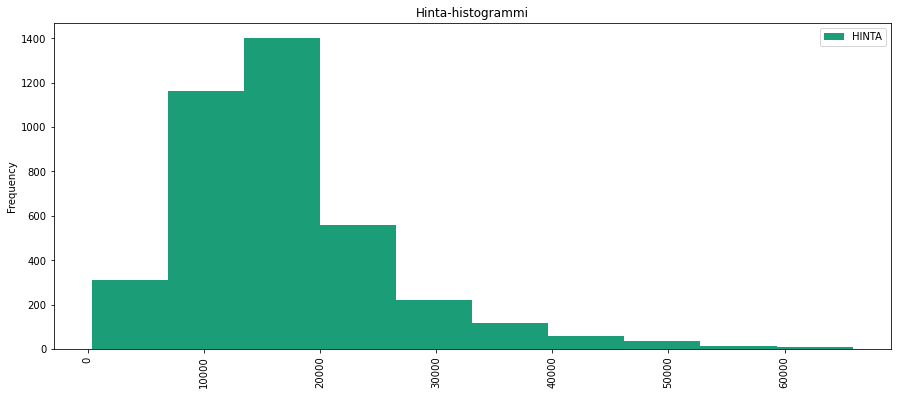

In [30]:
#Tutkitaan lyhyesti histogramissa kuinka paljon datasetissä on minkäkin hintaisia autoja
### Otetaan koeplotti datasta käyttäen Pandas plot ja tehdään siitä bar graph
df_org.plot(x='Merkki', y='HINTA', kind='hist', title= 'Hinta-histogrammi',cmap='Dark2', figsize=(15,6), rot=90)

Nähdään että hinnat ovat jokseenkin normaalijakautunutta. Ehkä jakauma muistuttaa vielä enemmän Poisson jakaumaa jollakin intensiteetin arvolla > 1. Keskihinta on 16890€, maksimihinta vuosimallivälillä 2005-2021 65860€ ja minimihinta 344€. Eli hajontaa on paljon tällä aikajaksolla

In [31]:
#Seuraavaksi tutkitaan dataframen mediaanihintaa, maksimihintaa ja minimihintaa
round(df_org['HINTA'].median(axis=0),0)

14900.0

In [32]:
round(df_org['HINTA'].max(axis=0),0)

65860

In [33]:
round(df_org['HINTA'].min(axis=0),0)

344

In [34]:
#Katsotaan paljonko mediaanihintaisia ilmoituksia dataframessa on
len(df_org.loc[df_org['HINTA']==14900])

51

In [35]:
#Tutkitaan vielä koko datasetin ominaisuuksia Pandaksen describe komennolla
df_org.describe(include='all')

,OTSIKKO,VM.,AJETTU,HINTA,URL,LINKKI ILMOITUKSEEN,HAUN AIKA,Merkki,Malli,Kaupunki
count,3882,3882.000000,3882.000000,3882.000000,3882,3882,3882,3882,3882,3882
unique,2795,NaN,NaN,NaN,42,3486,26,6,17,114
top,"Volkswagen Polo Trendline 1,0 59 kW (80 hv)",NaN,NaN,NaN,https://www.autotalli.com/vaihtoautot/listaa/v...,https://www.autotalli.com/vaihtoauto/38005359/...,Tue Apr 20 15:56:17 2021,volkswagen,qashqai,Vantaa
freq,57,NaN,NaN,NaN,100,2,271,896,351,283
mean,NaN,2014.100979,110239.465997,16890.255281,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,4.096127,71381.785715,8972.264062,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2005.000000,0.000000,344.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2011.000000,55000.000000,11400.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2015.000000,103441.500000,14900.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2017.000000,159000.000000,20890.000000,NaN,NaN,NaN,NaN,NaN,NaN


Erityisesti tästä kiinnostavat keskiarvot, keskihajonta, minimi ja maksimiarvot tärkeimmille muuttujille. Keskihinta on hieman korkeampi kuin mediaanihinta ja hajonta koko setissä on n.9000e. Keskimääräiset ajokilometrit 2005-2020 ajoneuvoille näyttäisi olevan 110239km. Ja keskimäärin autot ovat vuosimallia 2014 sarjassa. Volkswagen on selvästi suosituin merkki ja Nissan Qashqai näyttäisi olevan malleista suosituin. Autoja on selvästi eniten myynnissä Vantaalla.

In [36]:
#Tutkitaan miten jakautunutta automerkkien kesken data on
Merkkijakauma=df_org['Merkki'].value_counts()

<AxesSubplot:>

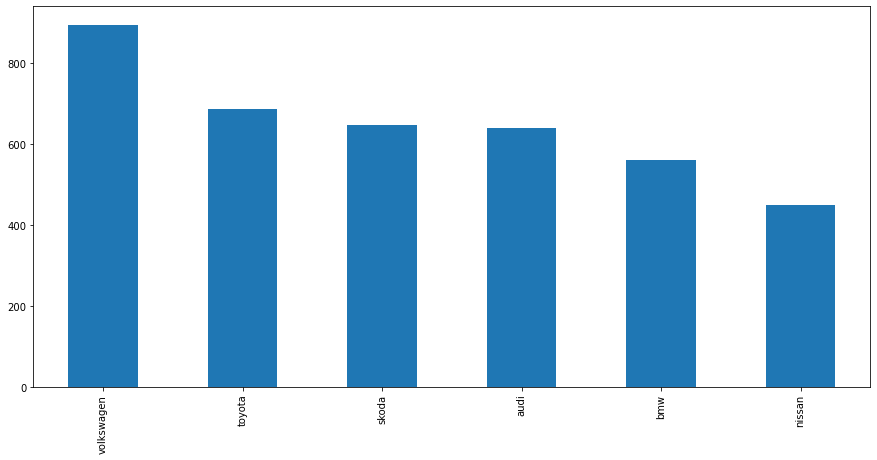

In [37]:
Merkkijakauma.plot.bar()

Datasetissa Volkswagen erottuu muista ilmoitusten määrällä kun taas Nissania on vain suunnilleen puolet. Datasetissä on siis aineisto jonkin verran epäbalanssissa ja jonkinlaista keinotekoista tasoitusta voidaan joutua tekemään seuraavissa vaiheissa

In [38]:
#Luodaan scatter kuvaajaa varten lista niistä muuttujista mitä halutaan tarkastella riippuvuussuhteiden osalta
scattercols=['HINTA','VM.','AJETTU']

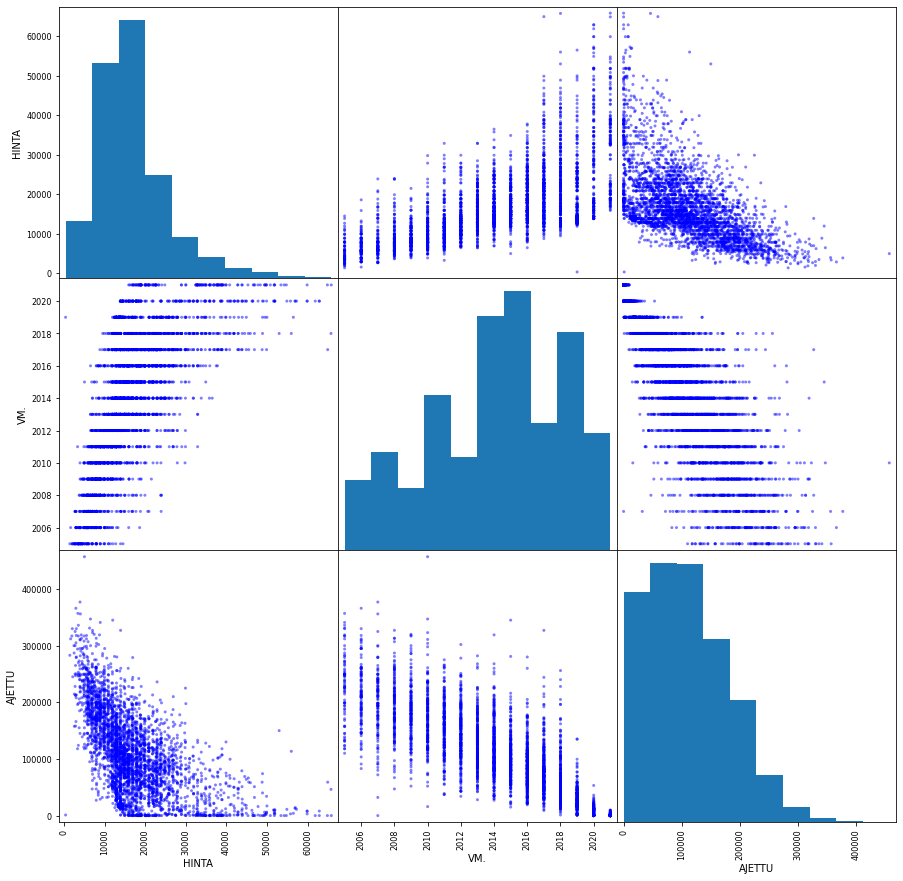

In [39]:
axs=pd.plotting.scatter_matrix(df_org[scattercols], figsize=(15,15), c='blue')

Nähdään että hintaan vaikuttavat molemmat sekä vuosimalli että ajokilometrit kuten olettaa saattoikin. 

In [40]:
#muutetaan Merkki, Malli ja Kaupunki sarakkeet numeerisiksi pandaksen factorizella
df_numeric=df_org

num_Merkki, uniques_Merkki = pd.factorize(df_numeric.Merkki.values, sort=True)
num_Malli, uniques_Malli = pd.factorize(df_numeric.Malli.values, sort=True)
num_Kaupunki, uniques_Kaupunki = pd.factorize(df_numeric.Kaupunki.values, sort=True)

df_numeric['Merkki_num']=num_Merkki
df_numeric['Malli_num']=num_Malli
df_numeric['Kaupunki_num']=num_Kaupunki


In [41]:
df_numeric.head()

,OTSIKKO,VM.,AJETTU,HINTA,URL,LINKKI ILMOITUKSEEN,HAUN AIKA,Merkki,Malli,Kaupunki,Merkki_num,Malli_num,Kaupunki_num
0,BMW 525 i Touring E61,2005,234000,5930,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38087770/...,Tue Apr 20 15:56:05 2021,bmw,5,Hattula,1,2,25
1,BMW 525 i Touring E61 A. Suomiauto. Kats 10/2021.,2005,249000,5990,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38070205/...,Tue Apr 20 15:56:05 2021,bmw,5,Hämeenlinna,1,2,30
2,BMW 525 *NELIVETO* BMW 525xi 4d A. Tarkastettu...,2006,236000,7490,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/38082748/...,Tue Apr 20 15:56:05 2021,bmw,5,Raisio,1,2,88
3,BMW 523 E61 Touring #PANORAAMAKATTO #SUOMIAUTO,2006,230000,7500,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37992120/...,Tue Apr 20 15:56:05 2021,bmw,5,Forssa,1,2,23
4,BMW 530 i 4d *HYVIN HUOLLETTU SUOMI-AUTO* * RA...,2007,299000,7850,https://www.autotalli.com/vaihtoautot/listaa/b...,https://www.autotalli.com/vaihtoauto/37961878/...,Tue Apr 20 15:56:05 2021,bmw,5,Kangasala,1,2,42


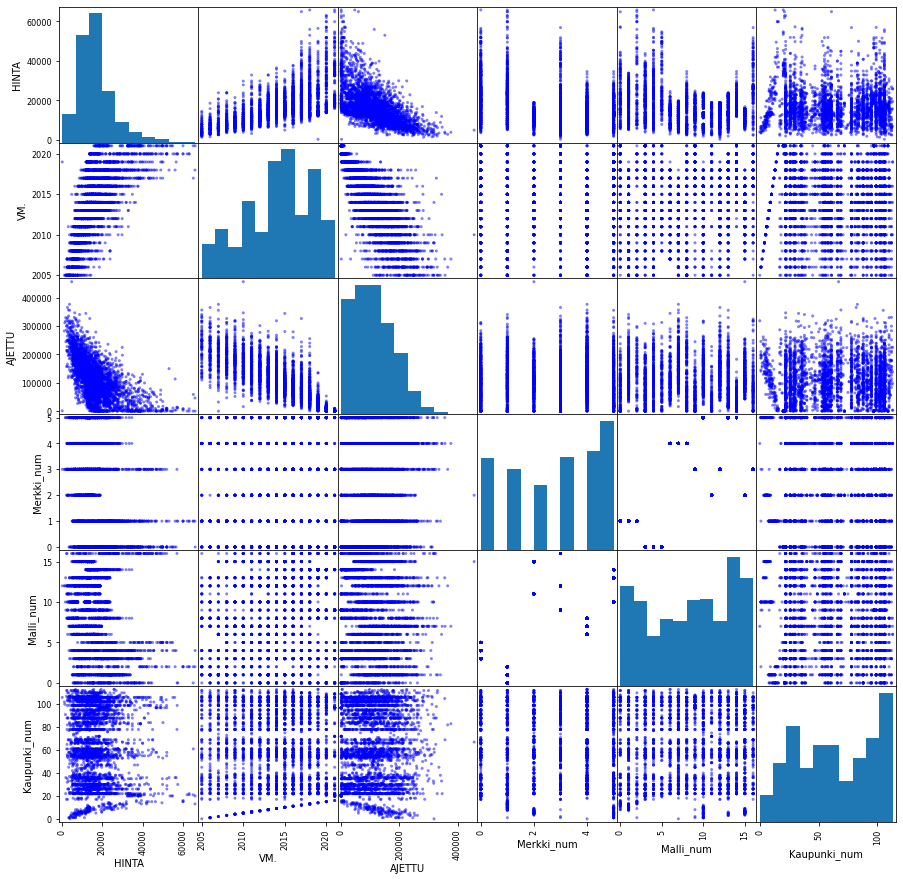

In [42]:
#Tämän jälkeen voidaan vielä tarkastella Scatter cols näkymässä riippuvuuksia Merkin, Mallin ja Kaupungin osalta
scattercols2=['HINTA','VM.','AJETTU','Merkki_num','Malli_num','Kaupunki_num']
axs2=pd.plotting.scatter_matrix(df_numeric[scattercols2], figsize=(15,15), c='blue')

Autojen hinnoissa näyttäisi olevan kovastikin vaihtelua eri merkkien välillä ja samoin on automalleissa kuten olettaa saattaa. Tosin lähes kaikissa automalleissa näyttäisi löytyvän myös sitä vähän edullisempaakin markkinoilla.

In [43]:
#tarkastelllaan mitkä vastaavudet automallien osalta on numeerisissa arvoissa.
pd.unique(df_numeric['Malli'])

array(['5', '3', 'a3', 'a4', 'a5', '1', 'qashqai', 'micra', 'fabia',
       'avensis', 'superb', 'auris', 'octavia', 'corolla', 'golf',
       'passat', 'polo'], dtype=object)

In [44]:
#ja numeerisessa taulukossa nämä vastaavuudet ovat
pd.unique(df_numeric['Malli_num'])

array([ 2,  1,  3,  4,  5,  0, 15, 11,  9,  7, 16,  6, 12,  8, 10, 13, 14],
      dtype=int64)

_______________________________________________________________________________________________________________________________

## Koneoppiminen

Pyritään hakemaan malli monimuuttujaregression avulla ennustamaan autojen hintaa. Aloitetaan jakamalla datasetti pelkästään numeerisiin muuttujiin eli poistamalla muut kuin numeerista dataa sisältävät sarakkeet. Sen jälkeen jaetaan datasetti opetus, testi ja validointisetteihin.

In [45]:
#tutkitaan datasettiä ensin korrelaatioiden valossa, negatiivinen luku tarkoittaa negatiivista korrelaatiota, positiivinen positiivista ja 0 tarkoittaa ei korrelaatiota.
print(df_numeric.corr())

                   VM.    AJETTU     HINTA  Merkki_num  Malli_num  \
VM.           1.000000 -0.796153  0.647576    0.049480   0.154725   
AJETTU       -0.796153  1.000000 -0.581148   -0.030452  -0.089567   
HINTA         0.647576 -0.581148  1.000000   -0.335577  -0.252464   
Merkki_num    0.049480 -0.030452 -0.335577    1.000000   0.616660   
Malli_num     0.154725 -0.089567 -0.252464    0.616660   1.000000   
Kaupunki_num -0.005906  0.011043 -0.036930    0.001818   0.019660   

              Kaupunki_num  
VM.              -0.005906  
AJETTU            0.011043  
HINTA            -0.036930  
Merkki_num        0.001818  
Malli_num         0.019660  
Kaupunki_num      1.000000  


In [46]:
#Luodaan funktiot kahta normalisointimenetelmää varten, ensimmäinen on standard score
def normalisoi(sarja):
    sarja_keskiarvo=np.mean(sarja)
    sarja_hajonta=np.std(sarja)
    sarja_norm=(sarja-sarja_keskiarvo)/sarja_hajonta
    return sarja_norm
#toinen min-max on normalisointi välille 0,1
def normalisoi_01(sarja):
    sarja_min=np.min(sarja)
    sarja_max=np.max(sarja)
    sarja01=(sarja-sarja_min)/(sarja_max-sarja_min)
    return sarja01


In [47]:
#yhdistä mallit ja numeerit funktio joka luo matriisin jossa ovat yhdistetty termin nimi yhdellä sarakkeella ja toisella termin numerotunnus
def yhdistä_numeeriin(teksti_sarja,numeeri_sarja):
    ts_temp=pd.unique(teksti_sarja)
    ns_temp=pd.unique(numeeri_sarja)
    yhdistetty=np.concatenate((np.reshape(ts_temp,(-1,1)),np.reshape(ns_temp,(-1,1))),axis=1)
    return yhdistetty

#ajetaan funktiolla matriisit malleista, merkeistä ja kaupungeista jotta myöhemmin osataan yhdistää numerot kuhunkin termiin
malli_yhdistetty=yhdistä_numeeriin(df_numeric['Malli'],df_numeric['Malli_num'])
merkki_yhdistetty=yhdistä_numeeriin(df_numeric['Merkki'],df_numeric['Merkki_num'])
kaupunki_yhdistetty=yhdistä_numeeriin(df_numeric['Kaupunki'],df_numeric['Kaupunki_num'])

In [48]:
#Jaetaan data kahtia Y-sarjaan joka kuvaa hintoja ja X-sarjaan johon sisältyvät piirteet Vuosimalli, Ajokilometrit, Malli, Kaupunki
#funktio joka luo matriisin regressiota varten X sarjalle, syötteinä:parametrien lista, alkuvuosi, loppuvuosi, automalli
#funktion syötteinä ovat parametrit listana, alkuvuosi, loppuvuosi, automalli (johon käy myös "Kaikki")
#funktion palautteena ovat X,Y matriisit sekä X,Y dataframet
def lisaa_parametri(parametrit,vuosi_a,vuosi_l,malli):
    malli_temp_num="Kaikki"
    kpl=""
    for i in range(len(malli_yhdistetty)):
        if malli == malli_yhdistetty[i][0]:
            malli_temp_num=malli_yhdistetty[i][1]
    if malli_temp_num!="Kaikki":
        
        Y_temp = df_numeric[(df_numeric['VM.'].between(vuosi_a,vuosi_l))&(df_numeric['Malli_num'] == malli_temp_num)]
        Y=Y_temp['HINTA'].values
        kpl=len(Y)
    else:
        Y_temp = df_numeric[df_numeric['VM.'].between(vuosi_a,vuosi_l)]
        Y=Y_temp['HINTA'].values
        kpl=len(Y)
        
    for i in range(len(parametrit)):
        #print(i)
        if i==0:
            if malli_temp_num != "Kaikki":
                
                X_temp=df_numeric[(df_numeric['VM.'].between(vuosi_a,vuosi_l))&(df_numeric['Malli_num'] == malli_temp_num)]
            else:
                X_temp=df_numeric[df_numeric['VM.'].between(vuosi_a,vuosi_l)]
            
            X=X_temp[parametrit[i]].values
            X=np.reshape(X,(-1,1))
        if i>0:
            if malli_temp_num != "Kaikki":
                X_temp=df_numeric[(df_numeric['VM.'].between(vuosi_a,vuosi_l))&(df_numeric['Malli_num'] == malli_temp_num)]
            else:
                X_temp=df_numeric[df_numeric['VM.'].between(vuosi_a,vuosi_l)]
                
            np_X_temp_i=X_temp[parametrit[i]].values
            #print(len(np_X_temp_i))
            X = np.concatenate((X, np.reshape(np_X_temp_i,(-1,1))), axis=1)
        else:
            pass
    print("Automalli:{} , vuosimallit:{}-{}, näytettä:{} kpl".format(malli,vuosi_a,vuosi_l,kpl))    
    return X,Y,X_temp,Y_temp
       

#Tämä funktio käyttää listaa ennustimista joita sovitetaan käyttäen opetusdataa, funktio palauttaa ennustimien tarkkuuden
# eri mittareilla ja Y-ennustematriisin
#Funktio printtaa myös käytettyjen ennustimien tarkkuuden joissa käytetään arviointiin: R2-scorea, keskimmäistä absoluuttista virhettä
# ja Poisson hajointaa, yksiköt ovat joko euroissa (ilman normalisointia), tai suhteellisia yksiköitä jos käytetänä normalisointia

def käytä_mallia(mat_malli,x_op,y_op,x_test,y_test,tuloksia):
    mallin_nimi=""
    mallin_nimi = mat_malli.__class__.__name__
    
    regr = mat_malli.fit(x_op,y_op)
    y_ennuste = mat_malli.predict(x_test)
    tulokset=[]
    
    if tuloksia=="Kyllä":
        tulokset.append(mallin_nimi)
        
        #tämä arvo on itse asiassa yhtä kuin R2-score joka lasketaan erillisellä rivillä alempana, ei siis tulosteta tätä
        temp_score = round(regr.score(x_test,y_test),3)
        #print("\t Malli:{} saavutti {} tarkkuuden=score testidatalla.".format(mallin_nimi,temp_score))
        tulokset.append(temp_score)
        
        temp_r2score= round(metrics.r2_score(y_test,y_ennuste),3)
        print("\t Malli:{} saavutti {} r2_score tarkkuuden testidatalla.".format(mallin_nimi,temp_r2score))
        tulokset.append(temp_r2score)
        
        temp_err_mae = round(metrics.median_absolute_error(y_test, y_ennuste),2)
        print("\t Mediaani absoluuttinen virhe {} yksikköä(euroa) testidatalla".format(temp_err_mae))
        tulokset.append(temp_err_mae)
        
        try:
            temp_err_mpd = round(metrics.mean_poisson_deviance(y_test,y_ennuste),2)
            print("\t Keskimääräinen Poisson hajonta {} yksikköä(euroa) testidatalla".format(temp_err_mpd))
            tulokset.append(temp_err_mpd)
        except:
            pass
        

        
        
        print("\t")
        
        
    
    else:
        pass
    
    return y_ennuste, regr, tulokset


In [49]:
#Tämä funktio laskee yllä määritellyllä käytä_malli funktiolla ja lisaa_parametri funktiolla varsinaiset testi ja opetusdatasetit
#funktio palauttaa myös alkuperäiset X ja Y dataframet joko normalisoituina tai ilman
#syötteinä funktiolle ovat parametrilista, alkukvuosi, loppuvuosi, valittu automalli (myös "Kaikki" mahdollinen), normalisointimetodi
#ja käytettävät laskentamallit (ennustimet) listana
def laske_mallilla(parametrilista,vuosi_a,vuosi_l,automalli,normalisointi,laskentamallit):
    X_temp,Y_temp,X_df,Y_df =lisaa_parametri(parametrilista,vuosi_a,vuosi_l,automalli)
    X_opetus, X_testi, Y_opetus, Y_testi = train_test_split(X_temp, Y_temp, test_size=0.3, random_state=0)
    
    if normalisointi=="standard_score":
            X_opetus=normalisoi(X_opetus)
            Y_opetus=normalisoi(Y_opetus)
            X_testi=normalisoi(X_testi)
            Y_testi=normalisoi(Y_testi)
        
    elif normalisointi=="min-max":
            X_opetus=normalisoi_01(X_opetus)
            Y_opetus=normalisoi_01(Y_opetus)
            X_testi=normalisoi_01(X_testi)
            Y_testi=normalisoi_01(Y_testi)
    else:
            pass
    for i in range(len(laskentamallit)):
        #tässä kohtaa käytetään eri laskentamalleja(ennustimia) ja kerätään kustakin tulokset matriisiin Y_kaikki_ennusteet
        #Y_kaikki_ennusteet voidaan tehdä myöhemmin kyselyjä tuloksista kullakin laskentamallilla
        if i==0:
            Y_kaikki_ennusteet,reggi_,tulokset_=käytä_mallia(laskentamallit[i],X_opetus,Y_opetus,X_testi,Y_testi,"Kyllä")

        if i>0:
            Y_ennuste,reggi_,tulokset_=käytä_mallia(laskentamallit[i],X_opetus,Y_opetus,X_testi,Y_testi,"Kyllä")
            Y_kaikki_ennusteet=np.vstack((Y_kaikki_ennusteet,Y_ennuste))

            
    return X_opetus, X_testi, Y_opetus, Y_testi, Y_kaikki_ennusteet, X_df

In [50]:
# Tässä funktiossa luodaan pistekuvaaja niillä piirteillä jotka käyttäjä on valinnut ja pistekuvaajan luontiin käytetään joko:
# yhdellä piirteellä suoraa lineaariregression tulostetta,
# kahdella tai useammalla piirteellä piirteet yhdistetään pääkomponenttianalyysia käyttäen yhdeksi piirteeksi josta tehdään tuloste
# Plot outputs, tässä Y_e[0] viittaa lineaariseen regression ennusteeseen
# muita laskentamallien tuloksia ei tässä tulosteta
def plot_pistekuvaaja(parametrilista,X_opetus,Y_opetus,X_testi,Y_testi,Y_e):
    if len(parametrilista)<2:
        plt.scatter(X_testi, Y_testi,  color='black')
        plt.plot(X_testi, Y_e[0], color='blue', linewidth=3)
        plt.xlabel(parametrilista[0])
        plt.ylabel("Hinnat")
        
        plt.title('Lineaariregressio hinnan ja valitun piirteen suhteen')
    
        plt.xticks(X_testi, rotation='vertical')

        plt.show()


    if len(parametrilista)>1:

        #tehdään dimensionaalisuuden karsinta datalle käyttäen pääkomponenttianalyysia (PCA), pudotetaan ennustavat piirteet yhteen
        #,jotta voidaan visualisoida usean muuttujan datasettiä 2-ulotteisesti

        mat_malli_temp=LinearRegression()
        data_pca_opetus = PCA(n_components=1, random_state=0).fit_transform(X_opetus)
        data_pca_testi = PCA(n_components=1, random_state=0).fit_transform(X_testi)
        regr_temp = mat_malli_temp.fit(data_pca_opetus,Y_opetus)
        y_ennuste_PCA = regr_temp.predict(data_pca_testi)

        plt.scatter(data_pca_testi, Y_testi,  color='black')
        plt.plot(data_pca_testi, y_ennuste_PCA, color='blue', linewidth=3)
        plt.xlabel("Usean muuttujan kombinaatio")
        plt.ylabel("Hinnat")

        plt.title('Lineaariregressio(dimensionaalisuus pudotettu PCA:lla)\n hinnan ja valittujen piirteiden suhteen')

        plt.show()

In [51]:
#Tässä funktiossa tehdään piirteiden merkityskaaviot ja tulosteet
#Piirteiden merkitystä analysoidaan kahdella metodilla: RandomForestRegressor sekä GradienBoostingRegressor
#syötteenä on parametrilista, dataframe, X_opetusdatapistematriisi, Y_opetusdatapistematriisi

def plot_piirteiden_merkitys(parametrilista,X_df, X_opetus, Y_opetus):
    try:
        # tutkitaan miten paljon piirteet vaikuttavat datassa
        #kerätään dataframesta vain yllä käytetyt numeeriset parametrit
        X_df_temp=X_df[parametrilista]
        #alustetaan randomforestregressor
        reg_temp = RandomForestRegressor(n_estimators=50)
        #sovitetaan opetusdatalla
        reg_temp.fit(X_opetus, Y_opetus)
        #luodaan uusi dataframe johon kerätään piirteet merkitysjärjestyksessä käyttäen regressoria
        df_piirteen_merkitys = pd.DataFrame(reg_temp.feature_importances_, index=X_df_temp.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
        #tulostaan palkkikuvaaja
        df_piirteen_merkitys.plot(kind='bar', title='Piirteiden merkitys- RandomForestRegressor')
        plt.show()

        #kokeillaan vielä toista regressorimenetelmää datasetin piirteille
        est_temp = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls').fit(X_opetus, Y_opetus)
        df_piirteen_merkitys2 = pd.DataFrame(est_temp.feature_importances_, index=X_df_temp.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
        #tulostaan palkkikuvaaja
        df_piirteen_merkitys2.plot(kind='bar', title='Piirteiden merkitys- GradientBoostingRegressor')
        plt.show()

        print("Piirteen merkitys RandomForestRegressor:\t")
        print(df_piirteen_merkitys)
        print("\t Piirteen merkitys GradientBoostingRegressor:\t")
        print(df_piirteen_merkitys2)
    except:
        Print("jotain meni pieleen merkitysten analysoinnissa")
    

In [52]:
#Käyttöliittymä alustetaan tässä
#Alustetaan interaktiiviset painikkeet jolla mallin lähtötietoja voi muuttaa, käytteän ipywidgets kirjastoa
slider1=widgets.IntRangeSlider(
    value=[2005, 2021],
    min=2005,
    max=2021,
    step=1,
    description='Vuosimallit:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

box1=widgets.Checkbox(
    value=False,
    description='AJETTU',
    disabled=False
)

box2=widgets.Checkbox(
    value=False,
    description='VM.',
    disabled=False
)

box3=widgets.Checkbox(
    value=False,
    description='Automallit',
    disabled=False
)

box4=widgets.Checkbox(
    value=False,
    description='Kaupungit',
    disabled=False
)

automallit=pd.unique(df_numeric['Malli'])
automallit=np.append(automallit,"Kaikki")

mallit_lista=widgets.Dropdown(
    options=automallit,
    value='Kaikki',
    description='Automalli:',
    disabled=False,
)

normalisointi_lista=widgets.Dropdown(
    options=["Ei normalisointia","standard_score","min-max"],
    value='Ei normalisointia',
    description='Normalisointi:',
    disabled=False,
)

#alustetaan vielä painike joka käynnistää laskennan
btn = widgets.Button(description='Laske valituilla')

#näytetään kaikki valintapainikkeet
display(slider1, box1,box2,box3,box4,mallit_lista,normalisointi_lista,btn)

#alustetaan tulosteille oma output() widgetti, tarvitaan kolme tulostetta: laskentamallien tulokset, lineaariregression plot ja piirteiden merkitys-plot
output_ = widgets.Output()
output_2= widgets.Output()
output_3= widgets.Output()

def btn_eventhandler(obj):
    output_.clear_output()
    output_2.clear_output()
    output_3.clear_output()
    with output_:

        vuosi_a=slider1.value[0]
        vuosi_l=slider1.value[1]
        ajettu_value=box1.value
        vm_value=box2.value
        malli_value=box3.value
        kaupunki_value=box4.value
        #merkki_value=box5.value
        automalli=mallit_lista.value
        norm_=normalisointi_lista.value


        parametrilista=[]
        if ajettu_value==True:
            parametrilista.append("AJETTU")
        if vm_value==True:
                parametrilista.append("VM.")
        if malli_value==True:
                parametrilista.append("Malli_num")
        if kaupunki_value==True:
                parametrilista.append("Kaupunki_num")
        #if merkki_value==True:
        #    parametrilista.append("Merkki_num")
        if len(parametrilista)==0:
            print("Mitään piirteitä ei valittu, ei voida laskea")

        if norm_=="Ei normalisointia":
            norm_=""

        laskentamallit=[LinearRegression(),linear_model.Lasso(alpha=0.1),linear_model.LassoLars(alpha=0.1),linear_model.Ridge(alpha=.5),linear_model.BayesianRidge(tol=0.001,alpha_1=100, alpha_2=100, lambda_1=1, lambda_2=1)]

        X_opetus, X_testi, Y_opetus, Y_testi, Y_e, X_df = laske_mallilla(parametrilista,vuosi_a,vuosi_l,automalli,norm_,laskentamallit)

        print(parametrilista)
        

    with output_2:        
        plot_pistekuvaaja(parametrilista,X_opetus,Y_opetus,X_testi,Y_testi,Y_e)
        
    with output_3:
        plot_piirteiden_merkitys(parametrilista,X_df, X_opetus, Y_opetus)
        
#painikkkeen painaminen kutsuu funktiota btn_evenhandler joka käynnistää laskennan annetuilla parametreilla
btn.on_click(btn_eventhandler)

#luodaan kolme eli tabia tulosten esittelyyn
tab = widgets.Tab([output_, output_2, output_3])
tab.set_title(0, 'Mallien tulokset')
tab.set_title(1, 'Regressiokuvaaja')
tab.set_title(2, 'Piirteiden merkitys')
display(tab)



IntRangeSlider(value=(2005, 2021), continuous_update=False, description='Vuosimallit:', max=2021, min=2005)

Checkbox(value=False, description='AJETTU')

Checkbox(value=False, description='VM.')

Checkbox(value=False, description='Automallit')

Checkbox(value=False, description='Kaupungit')

Dropdown(description='Automalli:', index=17, options=('5', '3', 'a3', 'a4', 'a5', '1', 'qashqai', 'micra', 'fa…

Dropdown(description='Normalisointi:', options=('Ei normalisointia', 'standard_score', 'min-max'), value='Ei n…

Button(description='Laske valituilla', style=ButtonStyle())